In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
original_macroregions = pd.io.stata.read_stata('../../../Downloads/Macrorregioes de Saude.dta')
original_macroregions

uf          cidade    ibge  macrorregiao            no_macro
0     AC      Acrelândia  120001             1    Macro única - AC
1     AC    Assis Brasil  120005             1    Macro única - AC
2     AC       Brasiléia  120010             1    Macro única - AC
3     AC          Bujari  120013             1    Macro única - AC
4     AC        Capixaba  120017             1    Macro única - AC
...   ..             ...     ...           ...                 ...
5565  TO  Tocantinópolis  172120           117  Macrorregião Norte
5566  TO        Tupirama  172125           117  Macrorregião Norte
5567  TO      Tupiratins  172130           117  Macrorregião Norte
5568  TO    Wanderlândia  172208           117  Macrorregião Norte
5569  TO         Xambioá  172210           117  Macrorregião Norte

[5570 rows x 5 columns]

In [3]:
# choosing the Brazilian state (e.g. 'AM', 'PA', BA', 'SP', 'RJ')
UF = 'RJ'

# choosing the IBGE municipalities dataset year (e.g. '2017 CD_GEOCMU', RJ:'2019 CD_MUN', RS:'2020 CD_MUN')
year = 2019
cod = 'CD_MUN'

# import the municipalities shapes
mun_df_original = gpd.read_file("../data/%s/%s_Municipios_%d.dbf"%(UF, UF, year))
mun_df_original[cod] = np.array([item[:-1] for item in np.array(mun_df_original[cod])]).astype('int') # trim last char

mun_df_original

CD_MUN              NM_MUN SIGLA_UF  AREA_KM2  \
0   330010      Angra dos Reis       RJ   813.210   
1   330015             Aperibé       RJ    94.542   
2   330020            Araruama       RJ   638.150   
3   330022               Areal       RJ   110.724   
4   330023  Armação dos Búzios       RJ    70.978   
..     ...                 ...      ...       ...   
87  330600           Três Rios       RJ   322.843   
88  330610             Valença       RJ  1300.767   
89  330615           Varre-Sai       RJ   201.938   
90  330620           Vassouras       RJ   536.073   
91  330630       Volta Redonda       RJ   182.105   

                                             geometry  
0   MULTIPOLYGON (((-44.15109 -23.21602, -44.15076...  
1   POLYGON ((-42.11437 -21.61204, -42.11394 -21.6...  
2   POLYGON ((-42.18249 -22.55269, -42.18221 -22.5...  
3   POLYGON ((-43.17348 -22.25628, -43.17353 -22.2...  
4   MULTIPOLYGON (((-41.91855 -22.81574, -41.91836...  
..                                                ...  
87  POLYGON ((-43.24571 -22.12649, -43.25882 -22.1...  
88  POLYGON ((-44.15907 -22.26109, -44.15901 -22.2...  
89  POLYGON ((-41.90989 -20.91191, -41.90989 -20.9...  
90  POLYGON ((-43.50355 -22.24108, -43.50285 -22.2...  
91  POLYGON ((-44.15429 -22.48666, -44.15377 -22.4...  

[92 rows x 5 columns]

In [4]:
mun_df = mun_df_original[['CD_MUN','geometry']].merge(original_macroregions[['ibge','no_macro']], 
                                        how = 'left', left_on = ['CD_MUN'], right_on = ['ibge'])
mun_df = mun_df.rename(columns={'no_macro': 'macroregion'})
mun_df = mun_df.drop(columns=['ibge'])

mun_df

CD_MUN                                           geometry  \
0   330010  MULTIPOLYGON (((-44.15109 -23.21602, -44.15076...   
1   330015  POLYGON ((-42.11437 -21.61204, -42.11394 -21.6...   
2   330020  POLYGON ((-42.18249 -22.55269, -42.18221 -22.5...   
3   330022  POLYGON ((-43.17348 -22.25628, -43.17353 -22.2...   
4   330023  MULTIPOLYGON (((-41.91855 -22.81574, -41.91836...   
..     ...                                                ...   
87  330600  POLYGON ((-43.24571 -22.12649, -43.25882 -22.1...   
88  330610  POLYGON ((-44.15907 -22.26109, -44.15901 -22.2...   
89  330615  POLYGON ((-41.90989 -20.91191, -41.90989 -20.9...   
90  330620  POLYGON ((-43.50355 -22.24108, -43.50285 -22.2...   
91  330630  POLYGON ((-44.15429 -22.48666, -44.15377 -22.4...   

         macroregion  
0    Metropolitana I  
1   Macrorregião III  
2   Macrorregião III  
3    Metropolitana I  
4   Macrorregião III  
..               ...  
87   Metropolitana I  
88   Metropolitana I  
89  Macrorregião III  
90   Metropolitana I  
91   Metropolitana I  

[92 rows x 3 columns]

In [5]:
from shapely.ops import cascaded_union
from shapely.geometry import Polygon

regions_boundary = []
year_regionalization = {region_name:"" for region_name in mun_df[mun_df['macroregion'].notna()]['macroregion'].unique()}

for region in mun_df[mun_df['macroregion'].notna()]['macroregion'].unique():
    mun_polygons = mun_df[mun_df['macroregion']==region]['geometry'].values
    region_polygon = cascaded_union(mun_polygons)

    if region_polygon.type == 'MultiPolygon':
        poly = Polygon(max(region_polygon, key=lambda a: a.area).exterior)
        regions_boundary.append(poly)
    else:
        poly = Polygon(region_polygon.exterior)
        regions_boundary.append(poly)
    year_regionalization[region] = [region_polygon.centroid.xy[0][0], region_polygon.centroid.xy[1][0]]
year_regionalization

{'Metropolitana I': [-43.93088259914695, -22.50640773396086],
 'Macrorregião III': [-41.74084505657541, -21.799306433880908],
 'Macrorregião II': [-42.78374566691811, -22.435006717319105]}

In [6]:
mun_df['latlong'] = mun_df['macroregion'].map(lambda r: year_regionalization[r])

In [15]:
mun_df[['CD_MUN', 'macroregion', 'latlong']].to_csv("../data/%s/regions/macroregions_latlong_2020.csv"%(UF), index=False)

In [7]:
mun_df[['CD_MUN', 'macroregion', 'latlong']]

CD_MUN       macroregion                                    latlong
0   330010   Metropolitana I   [-43.93088259914695, -22.50640773396086]
1   330015  Macrorregião III  [-41.74084505657541, -21.799306433880908]
2   330020  Macrorregião III  [-41.74084505657541, -21.799306433880908]
3   330022   Metropolitana I   [-43.93088259914695, -22.50640773396086]
4   330023  Macrorregião III  [-41.74084505657541, -21.799306433880908]
..     ...               ...                                        ...
87  330600   Metropolitana I   [-43.93088259914695, -22.50640773396086]
88  330610   Metropolitana I   [-43.93088259914695, -22.50640773396086]
89  330615  Macrorregião III  [-41.74084505657541, -21.799306433880908]
90  330620   Metropolitana I   [-43.93088259914695, -22.50640773396086]
91  330630   Metropolitana I   [-43.93088259914695, -22.50640773396086]

[92 rows x 3 columns]

Text(0.5, 1.0, 'Health Regions in the State of RJ (3 regions)')

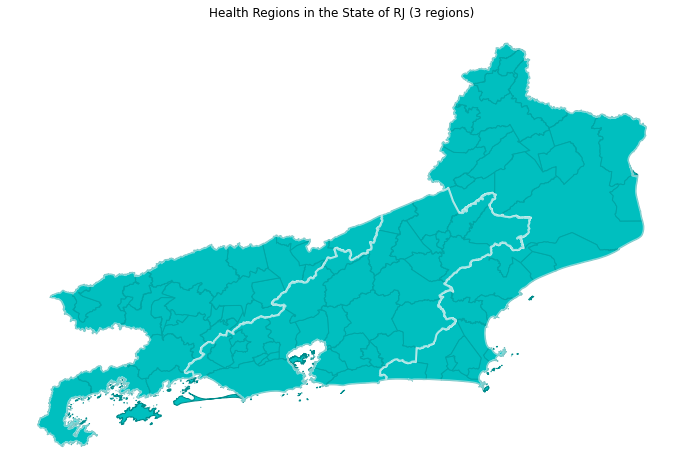

In [8]:
import matplotlib.pyplot as plt

# plot the health regions shape
fig, ax = plt.subplots(figsize=(12, 10))
gpd.GeoSeries(mun_df_original['geometry']).plot(ax=ax, color="c", edgecolor="darkcyan", lw=1)
gpd.GeoSeries(regions_boundary).plot(ax=ax, color="c", alpha=0.5, edgecolor="white", lw=2)
ax.axis("off")
plt.title("Health Regions in the State of %s (%d regions)"%(UF, len(regions_boundary)))
# plt.savefig("./regioes_%s.png"%UF, bbox_inches='tight')

In [10]:
gdf = gpd.GeoDataFrame({
    'name': mun_df[mun_df['macroregion'].notna()]['macroregion'].unique(),
    'geometry': regions_boundary
})

gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.01)
gdf.to_file("../data/%s/regions/macroregions.shp"%(UF))

-----------

In [12]:
# For the entire state
pol = cascaded_union(mun_df['geometry'].values)

Text(0.5, 1.0, 'Health Regions in the State of RJ (3 regions)')

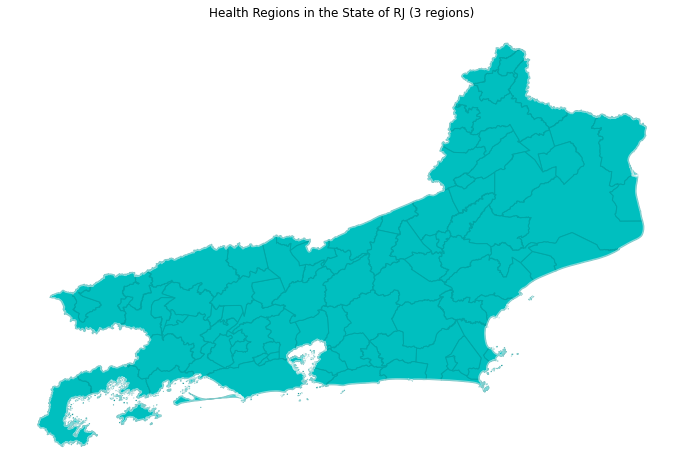

In [13]:
# plot the health regions shape
fig, ax = plt.subplots(figsize=(12, 10))
gpd.GeoSeries(mun_df_original['geometry']).plot(ax=ax, color="c", edgecolor="darkcyan", lw=1)
gpd.GeoSeries(pol).plot(ax=ax, color="c", alpha=0.5, edgecolor="white", lw=2)
ax.axis("off")
plt.title("Health Regions in the State of %s (%d regions)"%(UF, len(regions_boundary)))
# plt.savefig("./regioes_%s.png"%UF, bbox_inches='tight')

In [14]:
gdf = gpd.GeoDataFrame({
    'name': 'Rio de Janeiro',
    'geometry': pol
})

gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.01)
gdf.to_file("../data/%s/regions/state.shp"%(UF))